In [565]:
# https://arxiv.org/pdf/1903.07320.pdf

In [566]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [567]:
def hifi_model(x):
    return (6*x - 2)**2 * np.sin(12*x-4)

In [568]:
def lofi_model(x):
    return 0.5*hifi_model(x) + 10*(x-0.5) + 5

In [569]:
x = np.linspace(0, 1, 100)

In [570]:
lofi = lofi_model(x)
hifi = hifi_model(x)

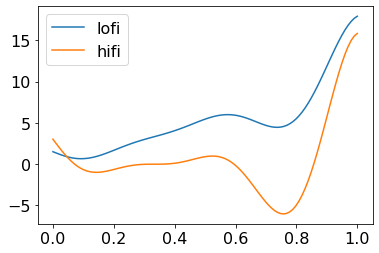

In [571]:
plt.figure()
plt.plot(x, lofi, label='lofi')
plt.plot(x, hifi, label='hifi')
plt.legend()

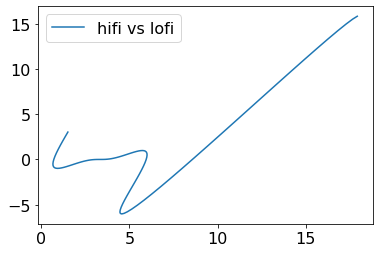

In [572]:
# Figure 6 in B.1: 1903.07320
plt.figure()
plt.plot(lofi, hifi, label='hifi vs lofi')
plt.legend()

# bridge functions

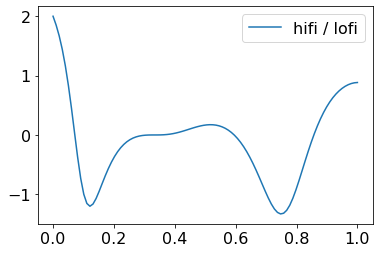

In [573]:
plt.figure()
plt.plot(x, hifi/lofi, label='hifi / lofi')
plt.legend()

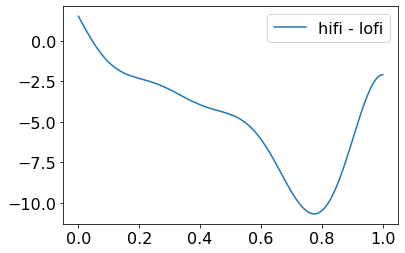

In [574]:
plt.figure()
plt.plot(x, hifi - lofi, label='hifi - lofi')
plt.legend()

# training and testing data

In [575]:
train_x = np.sort(np.random.uniform(size=(20, )))
test_x = np.sort(np.random.uniform(size=(4, )))

In [576]:
train_hifi = hifi_model(train_x)
test_hifi = hifi_model(test_x)

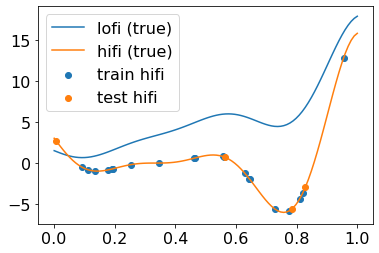

In [577]:
plt.figure()
plt.plot(x, lofi, label='lofi (true)')
plt.plot(x, hifi, label='hifi (true)')

plt.scatter(train_x, train_hifi, label='train hifi')
plt.scatter(test_x, test_hifi, label='test hifi')

plt.legend()

In [578]:
def fit(x, y, deg):
    return np.poly1d(np.polyfit(x, y, deg))

In [579]:
lofi_hat = fit(x, lofi, deg=9)

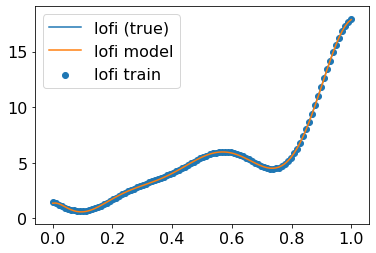

In [580]:
plt.figure()
plt.plot(x, lofi, label='lofi (true)')
plt.plot(x, lofi_hat(x), label='lofi model')

plt.scatter(x, lofi, label='lofi train')

plt.legend()

In [581]:
hifi_hat = fit(train_x, train_hifi, deg=2)

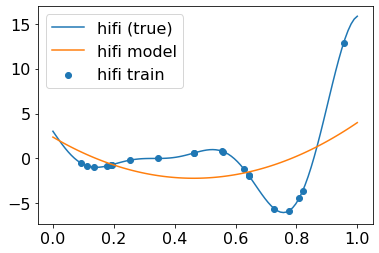

In [582]:
plt.figure()
plt.plot(x, hifi, label='hifi (true)')
plt.plot(x, hifi_hat(x), label='hifi model')

plt.scatter(train_x, train_hifi, label='hifi train')

plt.legend()

In [583]:
bridge_true = hifi - lofi

In [584]:
# i only know the bridge at the hifi points
# evaluate the lofi model at those points to estimate
# the bridge function

In [585]:
bridge_train = train_hifi - lofi_hat(train_x)

In [586]:
# approximation to the bridge function
bridge_hat = fit(train_x, bridge_train, deg=2)

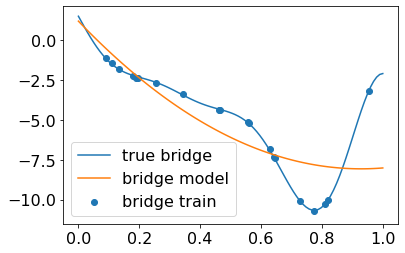

In [587]:
plt.figure()
plt.plot(x, bridge_true, label='true bridge')
plt.scatter(train_x, bridge_train, label='bridge train')
plt.plot(x, bridge_hat(x), label='bridge model')
plt.legend()

In [588]:
# multifidelity model: mfm
def mfm_func(x):
    return lofi_hat(x) + bridge_hat(x)

In [589]:
mfm = mfm_func(x)

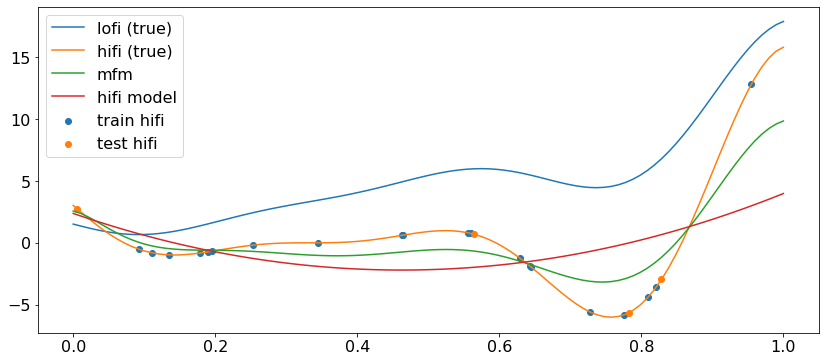

In [590]:
plt.figure(figsize=(14, 6))
plt.plot(x, lofi, label='lofi (true)')
plt.plot(x, hifi, label='hifi (true)')

plt.scatter(train_x, train_hifi, label='train hifi')
plt.scatter(test_x, test_hifi, label='test hifi')



plt.plot(x, mfm, label='mfm')

plt.plot(x, hifi_hat(x), label='hifi model')

plt.legend()

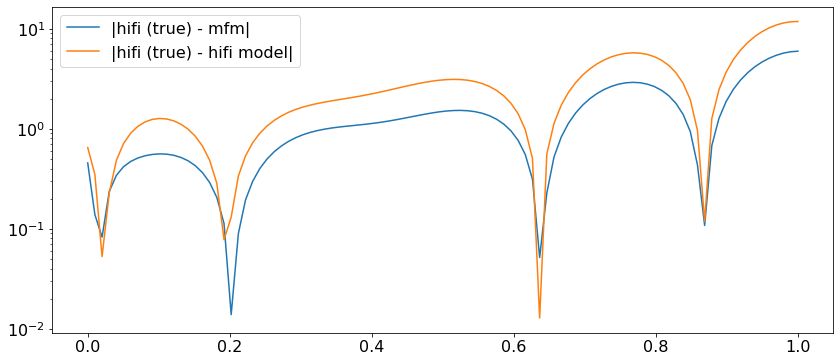

In [591]:
plt.figure(figsize=(14, 6))
plt.plot(x, np.abs(hifi-mfm), label='|hifi (true) - mfm|')
plt.plot(x, np.abs(hifi-hifi_hat(x)), label='|hifi (true) - hifi model|')

plt.yscale('log')

plt.legend()

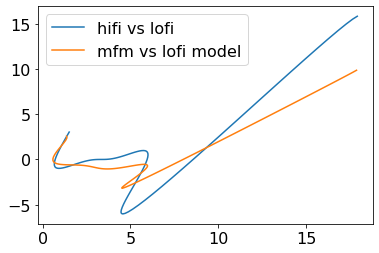

In [592]:
# Figure 6 in B.1: 1903.07320
plt.figure()
plt.plot(lofi, hifi, label='hifi vs lofi')

plt.plot(lofi_hat(x), mfm, label='mfm vs lofi model')

plt.legend()

# try fitting with GPR

In [593]:
import pymc3 as pm

In [594]:
# help from this example https://docs.pymc.io/notebooks/GP-Marginal.html

In [595]:
def fit_gp(X, y):
    with pm.Model() as model:
        ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
        η = pm.HalfCauchy("η", beta=5)

        cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
        gp = pm.gp.Marginal(cov_func=cov)

        σ = pm.HalfCauchy("σ", beta=5)
        y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

        mp = pm.find_MAP()
        
    return model, gp, mp

In [596]:
X = x[:,np.newaxis]
y = lofi

In [597]:
lofi_pm_model, lofi_gp, lofi_mp = fit_gp(X, y)

In [598]:
mu, var = lofi_gp.predict(X, point=lofi_mp, diag=False)

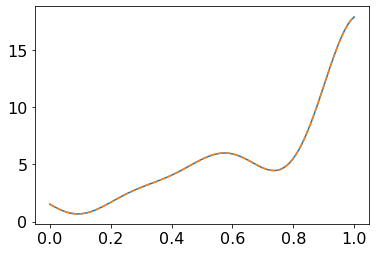

In [599]:
plt.figure()
plt.plot(X, y)
plt.plot(X, mu, ls='--')

In [600]:
X = train_x[:,np.newaxis]
y = train_hifi

In [601]:
hifi_pm_model, hifi_gp, hifi_mp = fit_gp(X, y)

In [602]:
mu, var = hifi_gp.predict(x[:,np.newaxis], point=hifi_mp, diag=False)

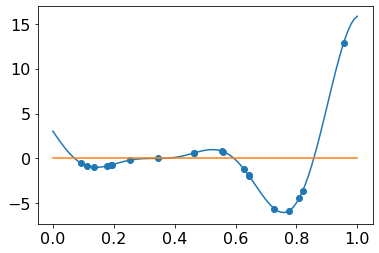

In [603]:
plt.figure()
plt.plot(x, hifi)
plt.scatter(X, y)
plt.plot(x, mu)

In [604]:
X = train_x[:,np.newaxis]
y = bridge_train

In [605]:
bridge_pm_model, bridge_gp, bridge_mp = fit_gp(X, y)

In [606]:
mu, var = bridge_gp.predict(x[:,np.newaxis], point=bridge_mp, diag=False)

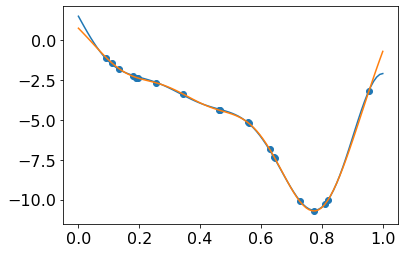

In [607]:
plt.figure()
plt.plot(x, bridge_true)
plt.scatter(X, y)
plt.plot(x, mu)

In [608]:
# multifidelity model: mfm
def mfm_gp_func(x):
    lofi_mu, lofi_var = lofi_gp.predict(x, point=lofi_mp, diag=False)
    bridge_mu, bridge_var = bridge_gp.predict(x, point=bridge_mp, diag=False)
    return lofi_mu, bridge_mu, lofi_mu + bridge_mu

In [609]:
lofi_mu, bridge_mu, mfm_gp_mu = mfm_gp_func(x[:,np.newaxis])

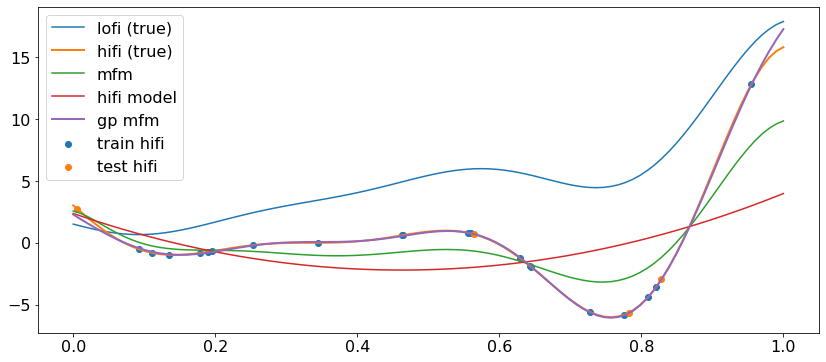

In [610]:
plt.figure(figsize=(14, 6))
plt.plot(x, lofi, label='lofi (true)')
plt.plot(x, hifi, label='hifi (true)', lw=2)

plt.scatter(train_x, train_hifi, label='train hifi')
plt.scatter(test_x, test_hifi, label='test hifi')



plt.plot(x, mfm, label='mfm')

plt.plot(x, hifi_hat(x), label='hifi model')


plt.plot(x, mfm_gp_mu, label='gp mfm', lw=2)

plt.legend()

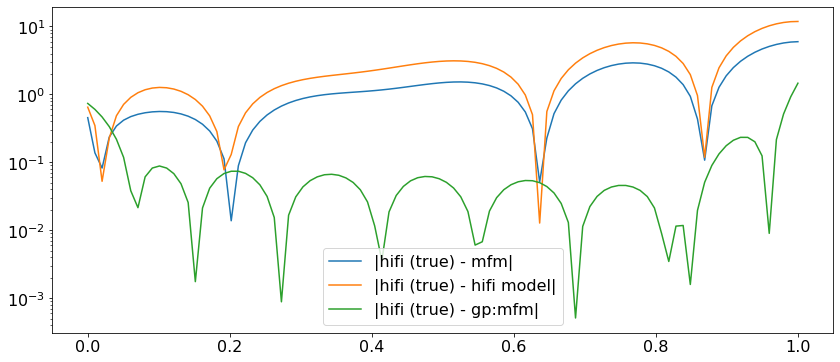

In [611]:
plt.figure(figsize=(14, 6))
plt.plot(x, np.abs(hifi-mfm), label='|hifi (true) - mfm|')
plt.plot(x, np.abs(hifi-hifi_hat(x)), label='|hifi (true) - hifi model|')

plt.plot(x, np.abs(hifi-mfm_gp_mu), label='|hifi (true) - gp:mfm|')


plt.yscale('log')

plt.legend()

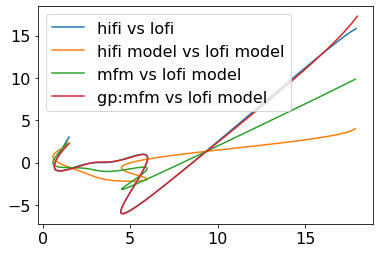

In [612]:
# Figure 6 in B.1: 1903.07320
plt.figure()
plt.plot(lofi, hifi, label='hifi vs lofi')

plt.plot(lofi_hat(x), hifi_hat(x), label='hifi model vs lofi model')

plt.plot(lofi_hat(x), mfm, label='mfm vs lofi model')

plt.plot(lofi_mu, mfm_gp_mu, label='gp:mfm vs lofi model')

plt.legend()